# Exploratory Data Analysis and Visualization in pandas

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

## [Seaborn](https://seaborn.pydata.org/tutorial.html) Plot Overview
- Histograms
    - [Histogram](#hist)
    - [Stacked Histogram](#stackedhist)
    - [Density Plot](#kde)
    - [Frequency Polygon Histogram](#polyhist)
- [Scatterplot](#scatter)
    - [Scatterplot with color classification](#colorscat)
- [Bar plot](#bar)
- [Line plot](#line)
- [Multiple plots in one figure](#fig)

---

The dataset we'll be working with is [Bike Share ridership](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/) data from the City of Toronto Open Data portal.

We can download it and save it in a folder as follows:

In [2]:
import urllib.request
import os

#os.makedirs("data") #only run once
year = 2022
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/7e876c24-177c-4605-9cef-e50dd74c617f/resource/db10a7b1-2702-481c-b7f0-0c67070104bb/download/bikeshare-ridership-" + str(year) + ".zip"
folder = "data"
urllib.request.urlretrieve(url, folder + "/bike-share-ridership-" + str(year) + ".zip")

('data/bike-share-ridership-2022.zip',
 <http.client.HTTPMessage at 0x7f21e4039510>)

The zip folder has `.csv` data for each month in the selected year. 

Since our data are zipped, we can either unzip the folder manually and run `df = pd.read_csv(path_to_csv_file)`.

Or we can load using the `zipfile` library. I'm feeding in variables for year and month that can easily allow for switching these out or looping over multiple in the future.

In [3]:
import zipfile

month = '01'

with zipfile.ZipFile("data/bike-share-ridership-" + str(year) + ".zip") as myzip:
    with myzip.open("bikeshare-ridership-" + str(year) + "/Bike share ridership " + str(year) + "-" + month + ".csv") as myfile:
        df = pd.read_csv(myfile)
        
df.head()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,14805109,4335,7334,01/01/2022 00:02,Simcoe St / Wellington St North,7269.0,01/01/2022 01:15,Toronto Eaton Centre (Yonge St),5139,Casual Member
1,14805110,126,7443,01/01/2022 00:02,Dundas St E / George St,7270.0,01/01/2022 00:05,Church St / Dundas St E - SMART,3992,Annual Member
2,14805112,942,7399,01/01/2022 00:04,Lower Jarvis / Queens Quay E,7686.0,01/01/2022 00:19,NaN,361,Annual Member
3,14805113,4256,7334,01/01/2022 00:04,Simcoe St / Wellington St North,7269.0,01/01/2022 01:15,Toronto Eaton Centre (Yonge St),4350,Casual Member
4,14805114,4353,7334,01/01/2022 00:05,Simcoe St / Wellington St North,7038.0,01/01/2022 01:17,Dundas St W / Yonge St,5074,Casual Member


Great! 

Let's start by looking at the trip duration column. I'm curious how long people are travelling by Bike Share.

The "Trip Duration" column is in seconds, that can be a bit a difficult to picture, let's create a column for minutes by dividing by 60. Also notice that the initial column has an extra space, probably just a typo when the data were created.

We can then compute some simple summary statistics on the column.

In [4]:
df["Trip Duration Minutes"] = df["Trip  Duration"] / 60
df["Trip Duration Minutes"].describe()

count    56765.000000
mean        14.930107
std        206.125166
min          0.000000
25%          6.183333
50%         10.016667
75%         16.050000
max      38095.650000
Name: Trip Duration Minutes, dtype: float64

<a class="anchor" id="hist"></a>
Cool! we've got the mean, standard deviation, and quantiles. The max trip is pretty crazy! Not sure if it's an error in the data, or someone just forgot to return their bike for that long.

The median (50%) being lower than the mean shows how their are definetly outliers.

Let's plot a distribution of shorter trips (those less than 2 hours long).

This will be our first forray into seaborn. We will specifically use trips that are less than 120 minutes.

Note as well that I am just plotting a random sample of 1000 observations. Could do them all, but plotting is slower.

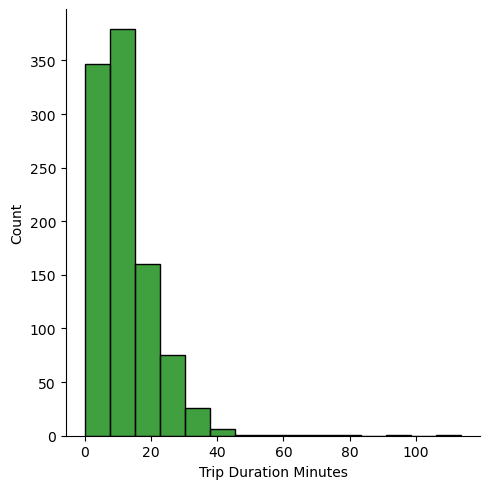

In [5]:
sns.displot(df.loc[df["Trip Duration Minutes"] <= 120, "Trip Duration Minutes"].sample(1000),
           bins = 15,
           color = "green")

Let's add some colour for user type <a class="anchor" id="stackedhist"></a>

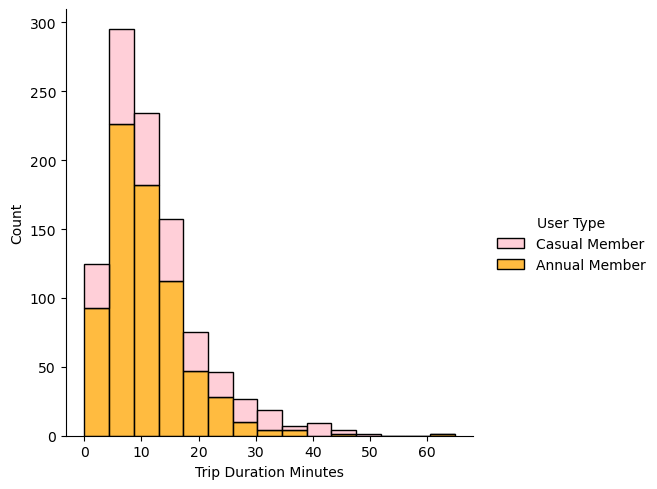

In [6]:
sns.displot(data = df.loc[df["Trip Duration Minutes"] <= 120].sample(1000),
            x = "Trip Duration Minutes",
            multiple = "stack",
            bins = 15,
            hue = "User Type",
            palette = ["pink", "orange"])

How about a plot of trips by day of the month, and colour by user type? We can comment on/off the colour parameter do add different lines by user type. We will do this in two ways: a kernal density plot <a class="anchor" id="kde"></a>

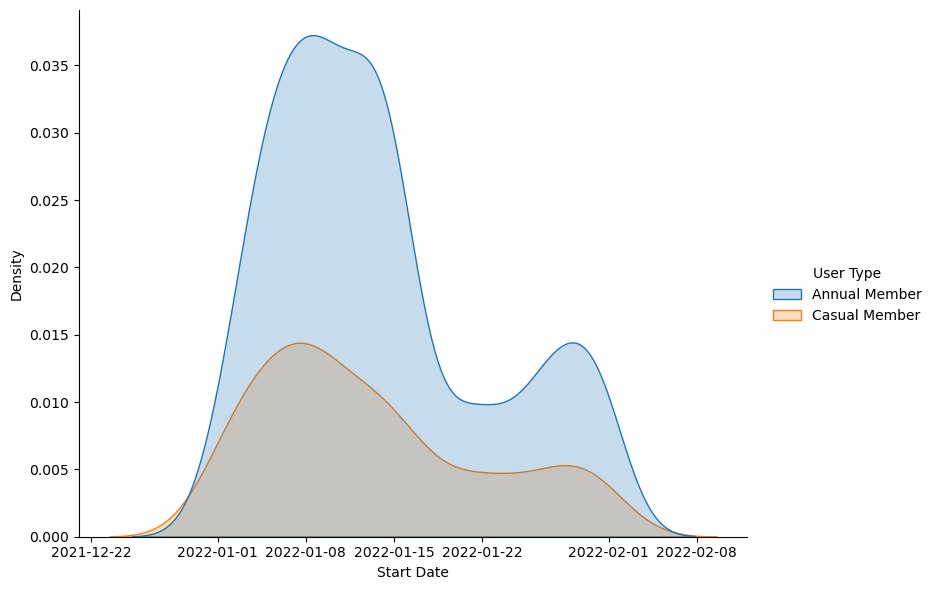

In [7]:
df['Start Date'] = pd.to_datetime(df['Start Time'], format='%m/%d/%Y %H:%M')
ddf = df.sort_values('Start Date')

sns.displot(ddf.loc[ddf["Trip Duration Minutes"] <= 120].sample(1000), 
            x="Start Date", 
            hue="User Type", 
            kind="kde", 
            fill=True,
            height=6, 
            aspect=11/8.5)

and a frequency polygon histogram <a class="anchor" id="polyhist"></a> <br>
_Note: to adjust the size using the `figsize` function, you must import plt_

<Axes: xlabel='Start Date', ylabel='Count'>

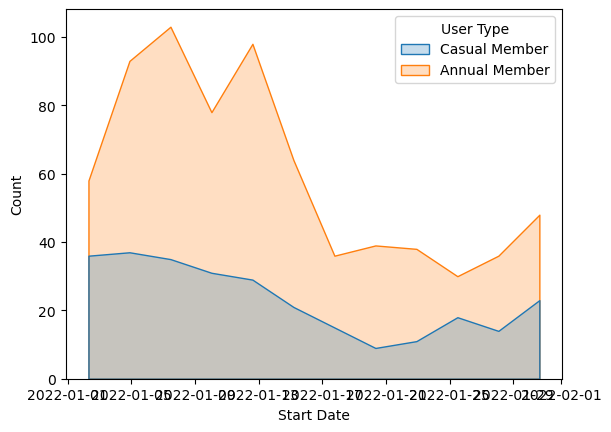

In [8]:
#fig, ax = plt.subplots(figsize=(11, 8.5))

sns.histplot(ddf.loc[ddf["Trip Duration Minutes"] <= 120].sample(1000), 
            x="Start Date", 
            hue="User Type",
           # ax = ax,
            element = "poly")

I'm curious if both types of members are likely to use Bike Share on the same dates. It's a bit difficult in this plot to see if there is correlation between the Annual Member and Casual Members. Let's make a scatter plot! Let's first do a group by to generate a smaller DataFrame of counts for each type. We can use the `pivot_table` function, very similar to Excel

In [9]:
df_date = df.pivot_table(index=df['Start Date'].dt.date, columns='User Type', aggfunc='size', fill_value=0).reset_index()

df_date["Start Date"] = df_date["Start Date"].astype(str)

df_date.head(5)


User Type,Start Date,Annual Member,Casual Member
0,2022-01-01,1613,1238
1,2022-01-02,830,305
2,2022-01-03,1488,669
3,2022-01-04,2430,941
4,2022-01-05,2175,695


and create a scatterplot <a class="anchor" id="scatter"></a>

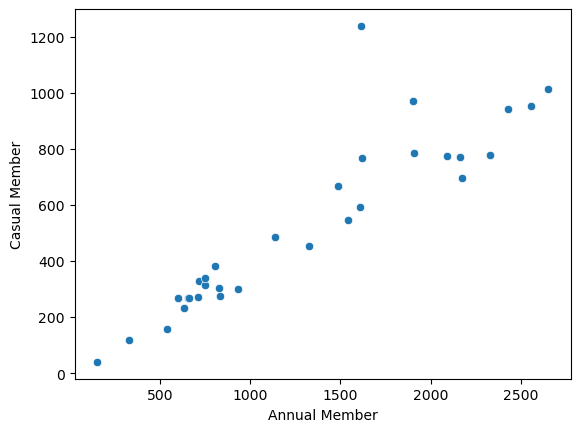

In [10]:
ax = sns.scatterplot(data=df_date, 
                x="Annual Member", 
                y="Casual Member",
               # hue = "Start Date",
               # palette = "flare",
                legend=True)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# uncomment the above lines to see what changes

We can also do a quickly compute a correlation between the two variables

In [11]:
from scipy.stats import pearsonr

pearsonr(df_date['Annual Member'], df_date['Casual Member'])

PearsonRResult(statistic=0.9037800081711291, pvalue=3.308526276108086e-12)

Let's try something a bit more analytical. Which stations have the most trips of people taking out and returning at the same place? <a class="anchor" id="bar"></a>

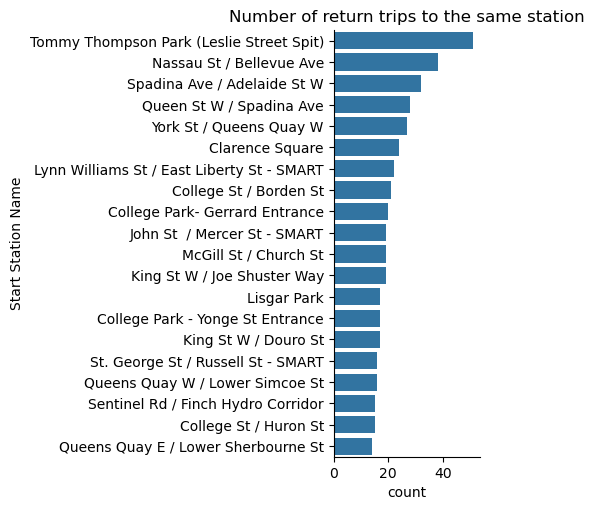

In [12]:
dfs = df.loc[df["Start Station Id"] == df["End Station Id"]]
dfs = dfs.groupby("Start Station Name").size().reset_index(name = "count")

sns.catplot(data= dfs.sort_values("count", ascending = False).head(20), 
            x='count', 
            y='Start Station Name',
            kind="bar").set(title = "Number of return trips to the same station")


# alt.Chart(
#     dfs.sort_values("count", ascending = False).head(20),
#     title = "Number of return trips to the same station"
# ).mark_bar(
#     opacity=0.8
# ).encode(
#     y = alt.Y("Start Station Name", sort='-x'),
#     x = alt.X("count"),
#     tooltip = "count"
# ).configure_axis(
#     labelLimit=300,
#     labelPadding=10,
#     title=None
# )

### Table Joins - Looking at Weather and Ridership

Okay! Let's do one last bit of analysis. Let's try to see how ridership is related to weather.

Let's first load in ALL the ridership data, and compute the total number of trips per day. This might take a little while, it's a lot of data to load!

In [13]:
df_months = []

for month in ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]:
    
    # for some reason, the data for November is zipped twice
    if month == "11":
        with zipfile.ZipFile("data/bike-share-ridership-" + str(year) + ".zip") as myzip:
            with myzip.open("bikeshare-ridership-" + str(year) + "/Bike share ridership " + str(year) + "-" + month + ".zip") as inner_zip_file:
                inner_zip = zipfile.ZipFile(inner_zip_file)
                with inner_zip.open("Bike share ridership " + str(year) + "-" + month + ".csv") as myfile:
                    df = pd.read_csv(myfile) 
                    df['Start Date'] = pd.to_datetime(df['Start Time'], format='%m/%d/%Y %H:%M').dt.date.astype(str)
                    df_month = df.groupby('Start Date')['Start Date'].count().reset_index(name='Count')
                    df_months.append(df_month)
    else:
        with zipfile.ZipFile("data/bike-share-ridership-" + str(year) + ".zip") as myzip:
            with myzip.open("bikeshare-ridership-" + str(year) + "/Bike share ridership " + str(year) + "-" + month + ".csv") as myfile:
                df = pd.read_csv(myfile)
                df['Start Date'] = pd.to_datetime(df['Start Time'], format='%m/%d/%Y %H:%M').dt.date.astype(str)
                df_month = df.groupby('Start Date')['Start Date'].count().reset_index(name='Count')
                df_months.append(df_month)

df_by_day = pd.concat(df_months)

df_by_day['Start DateTime'] = pd.to_datetime(df_by_day['Start Date'])

del df_months

Great! lets plot this <a class="anchor" id="line"></a>

<Axes: xlabel='Start DateTime', ylabel='Count'>

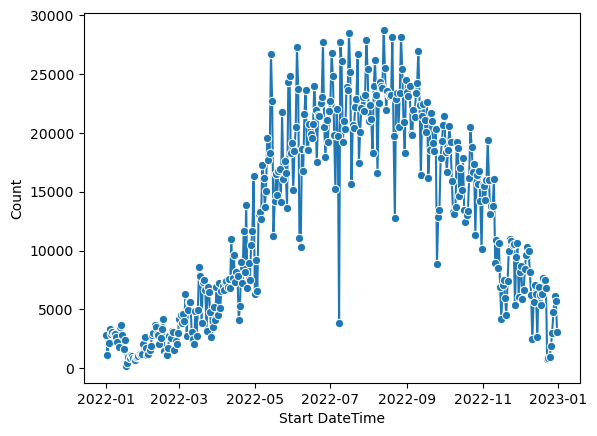

In [14]:
sns.lineplot(data=df_by_day, 
             x='Start DateTime', 
             y='Count',
            marker = "o")


Let's load in our weather data! This was accessed from the federal governments historical climate data website: https://climate.weather.gc.ca/index_e.html

In [15]:
df_weather = pd.read_csv("toronto-historical-weather-2022.csv")

df_weather.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-79.4,43.67,TORONTO CITY,6158355,2022-01-01,2022,1,1,NaN,5.1,...,NaN,NaN,2.4,NaN,NaN,NaN,NaN,M,NaN,M
1,-79.4,43.67,TORONTO CITY,6158355,2022-01-02,2022,1,2,NaN,-2.1,...,NaN,NaN,2.0,NaN,3.0,NaN,NaN,M,NaN,M
2,-79.4,43.67,TORONTO CITY,6158355,2022-01-03,2022,1,3,NaN,-4.0,...,NaN,NaN,0.0,NaN,3.0,NaN,NaN,M,NaN,M
3,-79.4,43.67,TORONTO CITY,6158355,2022-01-04,2022,1,4,NaN,3.3,...,NaN,NaN,0.0,NaN,3.0,NaN,NaN,M,NaN,M
4,-79.4,43.67,TORONTO CITY,6158355,2022-01-05,2022,1,5,NaN,4.9,...,NaN,NaN,0.3,NaN,3.0,NaN,NaN,M,NaN,M


There's a lot of data here we can look at, but let's keep it simple for now, just look at mean temperature (°C) and total precipitation (mm) and join it to our daily ridership DataFrame

In [16]:
df_ridership_weather = df_by_day.merge(df_weather[["Date/Time", "Mean Temp (°C)", "Total Precip (mm)"]], left_on="Start Date", right_on="Date/Time")
df_ridership_weather.head(5)

,Start Date,Count,Start DateTime,Date/Time,Mean Temp (°C),Total Precip (mm)
0,2022-01-01,2851,2022-01-01,2022-01-01,1.5,2.4
1,2022-01-02,1135,2022-01-02,2022-01-02,-6.3,2.0
2,2022-01-03,2157,2022-01-03,2022-01-03,-8.4,0.0
3,2022-01-04,3371,2022-01-04,2022-01-04,-1.2,0.0
4,2022-01-05,2870,2022-01-05,2022-01-05,0.2,0.3


<Axes: xlabel='Start DateTime', ylabel='Mean Temp (°C)'>

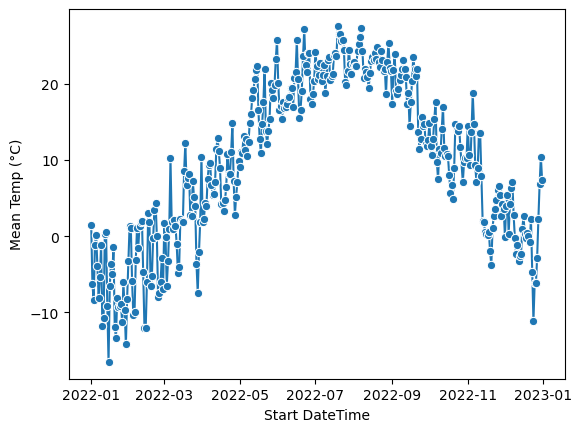

In [17]:
sns.lineplot(data=df_ridership_weather, 
             x='Start DateTime', 
             y='Mean Temp (°C)',
            marker = "o")

 <a class="anchor" id="fig"></a>
Let's look at the last two plots side by side

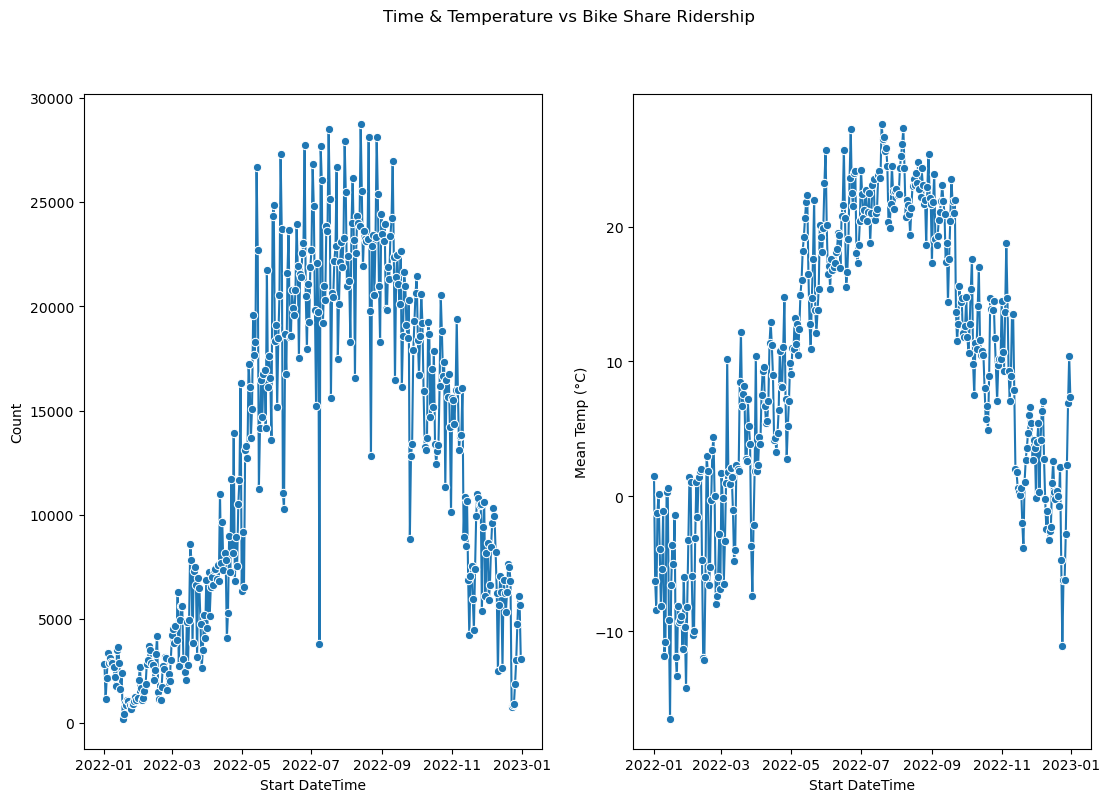

In [18]:
fig, axes = plt.subplots(1,2) #rows, columns

#first plot
ax = axes[0]

sns.lineplot(data=df_by_day, 
             x='Start DateTime', 
             y='Count',
            marker = "o",
            ax = ax)

#second plot
ax = axes[1]

sns.lineplot(data=df_ridership_weather, 
             x='Start DateTime', 
             y='Mean Temp (°C)',
            marker = "o",
            ax = ax)

#resize
plots = plt.gcf() #get current figure
plots.set_size_inches(13,8.5)
plots.suptitle("Time & Temperature vs Bike Share Ridership "); #Set title

<Axes: xlabel='Mean Temp (°C)', ylabel='Count'>

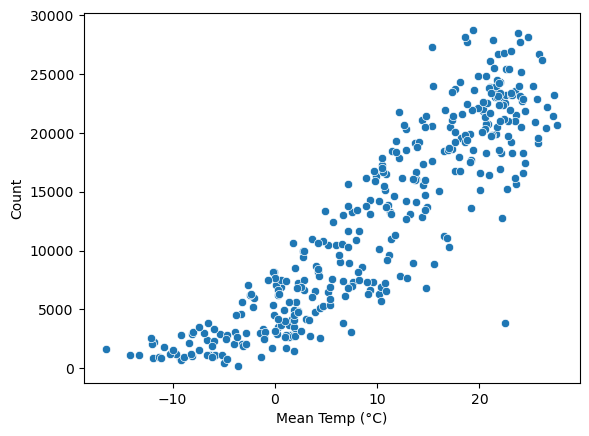

In [19]:
sns.scatterplot(data = df_ridership_weather,
               x="Mean Temp (°C)",
                y="Count")

Clearly pretty correlated! (except for the one outlier). How about we include a simple classification for precipitation and add it on the chart as a colour <a class="anchor" id="colorscat"></a>

<Axes: xlabel='Mean Temp (°C)', ylabel='Count'>

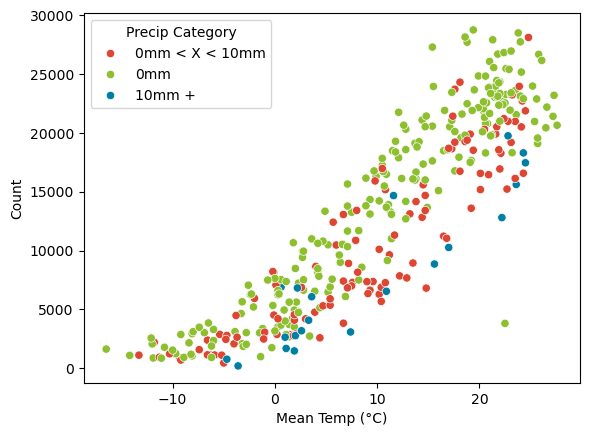

In [20]:
df_ridership_weather['Precip Category'] = df_ridership_weather['Total Precip (mm)'].apply(
    lambda x: '0mm' if x == 0 else ('0mm < X < 10mm' if 0 < x < 10 else '10mm +')
)

range_ = ['#DC4633', '#8DBF2E', '#007FA3']

sns.scatterplot(data = df_ridership_weather,
               x="Mean Temp (°C)",
                y="Count",
               hue = 'Precip Category',
               palette = range_)

Cool! clearly there is a trend here.

We can try to statistical model this trend via a linear regression model.

How does temperature and precipitation predict ridership per day?

[scikit-learn](https://scikit-learn.org/stable/index.html) is a commonly used library for statistical and machine learning modelling in Python.

Let's first just do a bivariate model:

In [21]:
import pandas as pd
import statsmodels.api as sm

df_ridership_weather.dropna(inplace=True)

X = df_ridership_weather[['Mean Temp (°C)']]
y = df_ridership_weather['Count']

# Add constant to the X matrix
X = sm.add_constant(X)

# Fit an OLS model and print the results
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     1525.
Date:                Thu, 02 May 2024   Prob (F-statistic):          7.54e-132
Time:                        14:37:02   Log-Likelihood:                -3495.4
No. Observations:                 364   AIC:                             6995.
Df Residuals:                     362   BIC:                             7003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5824.3977    256.883     22.

And now with the precipitation categories!

In [22]:
dummies = pd.get_dummies(df_ridership_weather['Precip Category'], prefix='Precip')

# Concatenate the dummy variables with the original dataframe
df_ridership_weather = pd.concat([df_ridership_weather, dummies], axis=1)

# Define the X and y variables for the regression model
X = df_ridership_weather[['Mean Temp (°C)', 'Precip_0mm', 'Precip_0mm < X < 10mm', 'Precip_10mm +']]
y = df_ridership_weather['Count']

# Add constant to the X matrix
X = sm.add_constant(X)

# Fit an OLS model and print the results
ols_model = sm.OLS(y, X.astype(float)).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     680.6
Date:                Thu, 02 May 2024   Prob (F-statistic):          6.09e-148
Time:                        14:37:02   Log-Likelihood:                -3450.5
No. Observations:                 364   AIC:                             6909.
Df Residuals:                     360   BIC:                             6925.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3243.53

> Count = 3243.54 + 686.34 * "Mean Temp (°C)" + 3863.46 * "Precip_0mm" + 1024.64 * "Precip_0mm" < X < 10mm - 1644.57 * "Precip_10mm +"

## Common Errors
Data visualization is more straight forward because you can rely on documentation, and errors often come from data wrangling errors than data viz errors. As a general note, Seaborn likes long format instead of wide format. Our data is already in long format, so we will make a month column and use it to convert this into wide format. 

In [23]:
df_ridership_weather.tail(68)

,Start Date,Count,Start DateTime,Date/Time,Mean Temp (°C),Total Precip (mm),Precip Category,Precip_0mm,Precip_0mm < X < 10mm,Precip_10mm +
296,2022-10-24,16671,2022-10-24,2022-10-24,13.8,0.0,0mm,True,False,False
297,2022-10-25,17351,2022-10-25,2022-10-25,14.5,0.0,0mm,True,False,False
298,2022-10-26,11315,2022-10-26,2022-10-26,11.7,7.9,0mm < X < 10mm,False,True,False
300,2022-10-28,15655,2022-10-28,2022-10-28,7.1,0.0,0mm,True,False,False
301,2022-10-29,16770,2022-10-29,2022-10-29,9.7,0.0,0mm,True,False,False
...,...,...,...,...,...,...,...,...,...,...
360,2022-12-27,3021,2022-12-27,2022-12-27,-2.8,0.0,0mm,True,False,False
361,2022-12-28,4737,2022-12-28,2022-12-28,2.3,0.0,0mm,True,False,False
362,2022-12-29,6096,2022-12-29,2022-12-29,6.9,0.0,0mm,True,False,False
363,2022-12-30,5676,2022-12-30,2022-12-30,10.4,9.6,0mm < X < 10mm,False,True,False


In [24]:
df_ridership_weather["Date/Time"].dtype

dtype('O')

In [25]:
obj = 'hello'

obj[0:2]

'he'

### Create a Month column with your groups

In [26]:
# write code to create a month column here

In [27]:
df_ridership_weather.head()

,Start Date,Count,Start DateTime,Date/Time,Mean Temp (°C),Total Precip (mm),Precip Category,Precip_0mm,Precip_0mm < X < 10mm,Precip_10mm +
0,2022-01-01,2851,2022-01-01,2022-01-01,1.5,2.4,0mm < X < 10mm,False,True,False
1,2022-01-02,1135,2022-01-02,2022-01-02,-6.3,2.0,0mm < X < 10mm,False,True,False
2,2022-01-03,2157,2022-01-03,2022-01-03,-8.4,0.0,0mm,True,False,False
3,2022-01-04,3371,2022-01-04,2022-01-04,-1.2,0.0,0mm,True,False,False
4,2022-01-05,2870,2022-01-05,2022-01-05,0.2,0.3,0mm < X < 10mm,False,True,False


### Convert into wide format

In [28]:
df_wide = df_ridership_weather.pivot(columns="Month", values = "Count", index = "index")
df_wide

KeyError: 'index'

Let's see what it would look like if we tried to plot this using wide data.

In [ ]:
sns.lineplot(data=df_wide, 
             x='Month', 
             y='Count',
            marker = "o")

### Back into Long Format

Of course our original dataset is in the long format, but let's convert it back into long using the pandas [melt function](https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt).

In [ ]:
df_long = pd.melt(df_wide)
df_long.head()

In [ ]:
sns.lineplot(data=df_long, 
             x='Month', 
             y='value',
            marker = "o")

## Looking at Documentation

Feel free to read more about the Seaborn library and what you can do with it [here](https://seaborn.pydata.org/tutorial.html). Try to play around with different kinds of graphs using the the bikeshare data. We will also look at it together and work through how to read the documentation together.

